# Проект Страховая компания "Хоть потоп" 

Нужно защитить данные клиентов страховой компании «Хоть потоп». Разработайте такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Обоснуйте корректность его работы.
Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

## 1. Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'darkgrid')
from scipy import stats as st

#models
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

# gridsearch
from sklearn.model_selection import GridSearchCV

#preprocess
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

# метрики
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer

In [2]:
try: 
    data = pd.read_csv('G:\Projects\praktikum\datasets\insurance.csv')
except:
    data = pd.read_csv('/datasets/insurance.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
Пол                  5000 non-null int64
Возраст              5000 non-null float64
Зарплата             5000 non-null float64
Члены семьи          5000 non-null int64
Страховые выплаты    5000 non-null int64
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


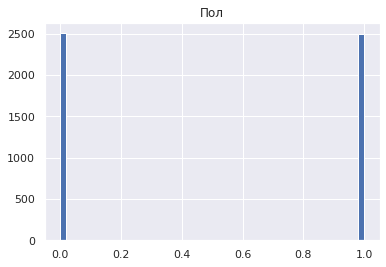

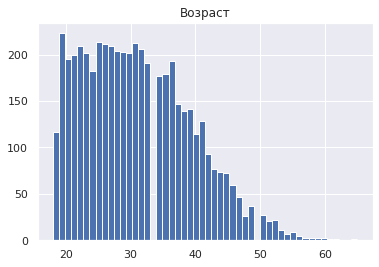

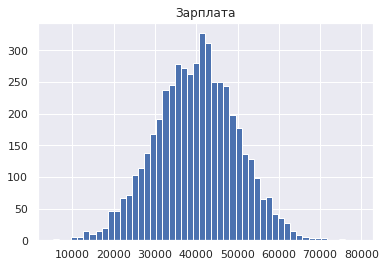

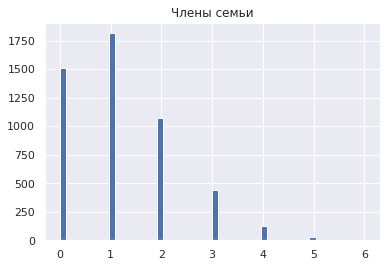

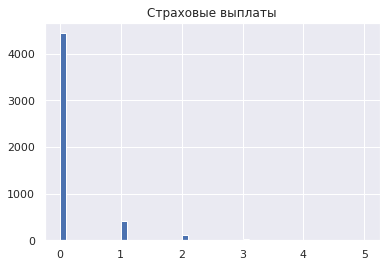

In [4]:
for each in data.columns:
    data.hist(each, bins=50)
    plt.show()

Данные загружены. Каких-то страшных аномалий в данных не наблюдается.

## 2. Ответьте на вопрос и обоснуйте решение.
#### Признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии? (Её можно обучить заново.)

Посмотрим на формулу линейной регрессии:<br/>
$X^TXw = X^Ty$, где <br/>
X-матрица признаков <br/>
w-вектор параметров линейной регрессии <br/>
y-вектор целевых признаков <br/>

Домножим матрицу признаков на обратимую квадратную матрицу А.<br/> 
Вектор параметров очевидно изменится, обозначим его через $w_1$, запишем изменённую формулу и посмотрим на связь $w$ и $w_1$:

$(XA)^T(XA)w_1 = (XA)^Ty$ <br/>
Раскроем скобки: <br/>
$A^TX^TXAw_1 = A^TX^Ty$ <br/>

Так как матрица А обратимая, $A^T$ тоже обратимая. Домножим обе стороны уравнения на $(A^T)^(-1) (слева)$: <br/>
$X^TX(Aw_1) = X^Ty$ <br/>
Избавились от $A^T$ и получили ту же формулу линейной регрессии, где параметры w равны произведению матрицы А на некоторый вектор($w_1$) - вектор новых параметров:<br/>
$w = Aw_1$ <br/>
Так как матрица А обратимая, умножение вектора параметров на неё не меняет размерности пространства вектора параметров. А значит переобученная модель линейной регрессии просто подберёт новую комбинацию линейных "весов", что не повлияет на метрику качества (в частности R2). 

Проверим на практике!

In [6]:
# разобьём сет на выборки
data_train, data_valid = train_test_split(data, train_size = 0.75)
data_train.shape

(3750, 5)

In [7]:
# выделим признаки
features_train = data_train.drop('Страховые выплаты', axis=1)
target_train = data_train['Страховые выплаты'] 

features_valid = data_valid.drop('Страховые выплаты', axis=1)
target_valid = data_valid['Страховые выплаты'] 

In [85]:
num_cols = ['Возраст', 'Зарплата', 'Члены семьи']
scaler = StandardScaler()
scaler.fit(features_train[num_cols])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [86]:
features_train[num_cols] = scaler.transform(features_train[num_cols])
features_valid[num_cols] = scaler.transform(features_valid[num_cols])

In [8]:
features_valid.head(10)

,Пол,Возраст,Зарплата,Члены семьи
3778,1,18.0,22000.0,1
4908,1,40.0,33200.0,1
349,1,28.0,25500.0,0
1292,0,23.0,48000.0,1
393,0,25.0,28500.0,2
4717,1,30.0,49600.0,2
2322,0,44.0,25300.0,1
1801,0,35.0,54800.0,0
1202,0,23.0,34500.0,2
4513,0,46.0,53400.0,0


Обучим модель линейной регрессии на исходном сете и посмотрим метрику R2:

In [9]:
model = LinearRegression()
model.fit(features_train, target_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [46]:
print('R2-score исходной модели:', model.score(features_valid, target_valid))

R2-score исходной модели: 0.42886323520785197


R2 модели для исходного датасета получилась 0.42886.

Создадим обратимую матрицу 4х4 и домножим матрицу признаков на неё.

In [20]:
A = np.random.randint(1,10,size=(4,4))
A

array([[9, 4, 9, 7],
       [5, 4, 4, 6],
       [1, 5, 7, 3],
       [7, 6, 9, 8]])

In [38]:
# проверим, что матрица обратима
np.linalg.inv(A) @ A

array([[ 1.00000000e+00,  1.77635684e-15,  1.77635684e-15,
         8.88178420e-16],
       [-1.77635684e-15,  1.00000000e+00, -1.77635684e-15,
         1.77635684e-15],
       [ 1.11022302e-15,  0.00000000e+00,  1.00000000e+00,
        -2.22044605e-16],
       [ 3.55271368e-15, -1.77635684e-15,  1.77635684e-15,
         1.00000000e+00]])

In [39]:
# домножаем матрицы признаков на матрицу А
features_train_1 = feat @ A
features_valid_1 = features_valid @ A
features_1.head()

,0,1,2,3
3124,50426.0,251598.0,352206.0,151047.0
3250,29473.0,146636.0,205247.0,88103.0
3363,50234.0,250184.0,350189.0,150277.0
1301,52416.0,261590.0,366198.0,157035.0
3640,53044.0,264616.0,370422.0,158872.0


In [40]:
# для чистоты эксперимента обучим новую модель
model_1 = LinearRegression()
model_1.fit(features_train_1, target_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [47]:
# смотрим скор R2
print('R2-score модели с изменёнными признаками:', model_1.score(features_valid_1, target_valid))

R2-score модели с изменёнными признаками: 0.42886323520762015


Метрика R2 для новой модели получилась в точности равна метрики модели, обученной на изначальных данных. ЧТД

## 3. Предложите алгоритм преобразования данных для решения задачи деперсонализации данных в исходном датасете

В п.2 по сути и был показан и доказан алгорит приобразования обучающего датасета, не влияющего на качетство линейной регрессии.

Также был приведён пример преобразованной матрицы признаков (умноженной на квадратную обратимую), из который невозможно узнать реальные значения признаков, не зная матрицы преобразования А.

In [45]:
# пример матрицы признаков, умноженной на случайную обратимую матрицу
pd.DataFrame(features_train_1, columns=features_train.columns)

,Пол,Возраст,Зарплата,Члены семьи
0,50426.0,251598.0,352206.0,151047.0
1,29473.0,146636.0,205247.0,88103.0
2,50234.0,250184.0,350189.0,150277.0
3,52416.0,261590.0,366198.0,157035.0
4,53044.0,264616.0,370422.0,158872.0
...,...,...,...,...
3745,69072.0,344638.0,482441.0,206906.0
3746,37569.0,187136.0,261942.0,112402.0
3747,28842.0,143614.0,201017.0,86270.0
3748,21914.0,109092.0,152698.0,65536.0


# Выводы:
Целью работы была разработка метода преобразования данных, чтобы по ним было сложно восстановить персональную информацию. 

В ходе работы была проверена и доказана теория, что умножение матрицы признаков на обратимую матрицу не меняет качества обучения модели линейной регрессии. Следовательно, подобный подход можно использовать для целей исследования - преобразования исходных данных.

Для проверки подхода, были обучены две модели линейной регрессии - на исходном датасете и признаках умноженных на обратимую матрицу. Полученные целевые метрики моделей регрессии при этом оказались равны.